# Alzheimer CNN
This neural-network uses convolution-layers to predict the state of Alzheimer's disease, from an inputted MRI scan photo. This can substantially contribute to doctors who want to provide unique care for each patient and their state.


In [1]:
# Import google drive contents
from google.colab import drive
drive.mount('/content/drive', force_remount=True) # Force a remount in case it was already mounted in the session

Mounted at /content/drive


In [2]:
import pandas as pd

train_df = pd.read_parquet('/content/drive/MyDrive/Alzheimer Data/Train.parquet') # Read off the training dataframe
test_df = pd.read_parquet('/content/drive/MyDrive/Alzheimer Data/Test.parquet') # Read off the testing dataframe

print( train_df.columns )
print( test_df.columns )

Index(['image', 'label'], dtype='object')
Index(['image', 'label'], dtype='object')


In [3]:
print( train_df['image'].iloc[0] ) # Since we figured each image is a dictionary we will print it out

{'bytes': b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x01\x01,\x01,\x00\x00\xff\xdb\x00C\x00\x03\x02\x02\x03\x02\x02\x03\x03\x03\x03\x04\x03\x03\x04\x05\x08\x05\x05\x04\x04\x05\n\x07\x07\x06\x08\x0c\n\x0c\x0c\x0b\n\x0b\x0b\r\x0e\x12\x10\r\x0e\x11\x0e\x0b\x0b\x10\x16\x10\x11\x13\x14\x15\x15\x15\x0c\x0f\x17\x18\x16\x14\x18\x12\x14\x15\x14\xff\xc0\x00\x0b\x08\x00\x80\x00\x80\x01\x01\x11\x00\xff\xc4\x00\x1d\x00\x00\x02\x03\x01\x01\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x07\x05\x06\x08\x04\x02\x03\x01\t\xff\xc4\x008\x10\x00\x01\x03\x03\x03\x02\x05\x03\x01\x05\x08\x03\x00\x00\x00\x00\x01\x02\x03\x04\x00\x05\x11\x06\x07\x12!1\x13"AQa\x142q\x81\x08\x15R\x91\xa1#$3Bb\x92\xb1\xd1\x16r\x82\xff\xda\x00\x08\x01\x01\x00\x00?\x00\xfeUQE\x14QE\x14QE\x14QE\x14QE\x14W\xea\x1bS\x8bJ\x12\x92\xa5(\xe0$\x0c\x92\x7f\x157\x07BjK\x9a\x1c\\;\x05\xceRZ\xfb\xd4\xd4G\x14\x13\xf9\xc0\xe9\xd8\xd4l\xfbL\xdbZ\xf8\xcc\x86\xfcU{<\xd9G\xcf\xadu\xda\xb4\x95\xee\xfaH\xb6\xd9\xe7O\xc63\xf4\xd1\x96\xe63\xdb\xb0\xae\x

In [4]:
import numpy as np
import cv2
from PIL import Image
from io import BytesIO

IMG_SIZE = 180 # Resized images-scale
TOTAL_CLASSES = 4 # Total classes in this model

def process_image(bin_image):
    """"

        Processes a binary-image exctracted from the parquet data-frame and converts it to match the neural-network's requirements, as well as conversion into a matrix.

    """

    img = Image.open(BytesIO(bin_image['bytes'])) # Decode binary image into a matrice
    img = img.resize((IMG_SIZE, IMG_SIZE)) # We neglect aspect ratio differs
    img = img.convert('RGB') # Ensure 3 color channels
    img_arr = np.array(img) # Convert the image array into a numpy array
    return img_arr

# Process all dataframe images
train_images = np.array([ process_image(img_data) for img_data in train_df['image'] ]) # Construct a numpy array containing each training image
test_images = np.array([ process_image(img_data) for img_data in test_df['image'] ]) # ^ for test images

# Normalize all pixel colors
train_images = train_images / 255.0
test_images = test_images / 255.0

# Extract all image labels
train_labels = train_df['label'].values
test_labels = test_df['label'].values

In [5]:
# The dataframe is split in such a way, that for each image, in it's corresponding index within the labels array, are numbers from 0 to 3.
# 0 - Mild demented
# 1 - Moderate demented
# 2 - Non demented
# 3 - Very mild demented

label_correspondences = [ 'Mild demented', 'Moderate demented', 'Non demented', 'Very mild demented' ]

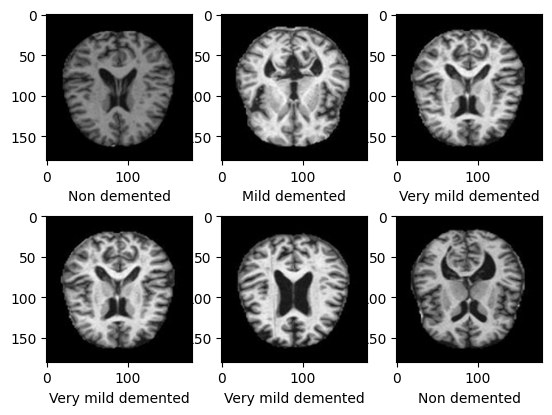

In [6]:
import matplotlib.pyplot as plt

# Define the shape of the preview images
rows = 2
columns = 3

# Cosntruct the subplots to display the preview images
fig, axs = plt.subplots(rows, columns)

for i in range(rows): # Iterate through the rows
    for j in range(columns): # Iterate through the columns in each row
        ax = axs[i, j] # Select the current plot axis
        index = 2*i + j # Compute the index of the image to pick from the training images to display
        img = train_images[index] # Grab that image from the training images array
        ax.imshow( img ) # Display the image within the specific axis
        ax.set_xlabel(  label_correspondences[train_labels[ index ]] or 'Undefined'  )

In [7]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Since we are working on a multi-class classification we must use categorical regression
le = LabelEncoder()
train_labels = le.fit_transform(train_labels)
test_labels = le.transform(test_labels)

# All labels are now converted into one-hot encoding for all different classes
train_labels = to_categorical(train_labels, num_classes=TOTAL_CLASSES)
test_labels = to_categorical(test_labels, num_classes=TOTAL_CLASSES)

<ipython-input-8-ee25406a49e1>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='label', y='count', data=counts, palette='viridis')


Text(0, 0.5, 'Total Training Images')

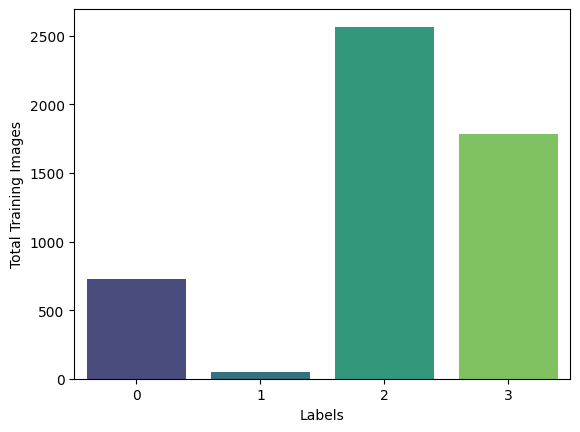

In [8]:
import seaborn as sns
counts = train_df['label'].value_counts().reset_index()

sns.barplot(x='label', y='count', data=counts, palette='viridis')
plt.xlabel('Labels')
plt.ylabel('Total Training Images')

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# Now we will finally construct the convolutional layers of our neural network
# The flow of our network is going from small convulutional filters into bigger ones

# We prefer relu over other activation functions due to optimization purposes.
model = Sequential([
    # 1st convolution layer
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    MaxPooling2D((2, 2)),

    # 2nd convolution layer
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # 3rd convolutional layer
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    # Flatten the output and convert all features into vectors
    Flatten(),

    # Fully connected layer
    Dense(64, activation='relu'),
    Dropout(0.5), # Avoid overfitting by making the model not overly sensitive to noise

    # Output layer
    Dense(TOTAL_CLASSES, activation='softmax') # Finally output the classifer out of all 4 classes
])

model.summary() # Visualize the model's contents

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       3,276,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,370,372 (12.86 MB)

 Trainable params: 3,370,372 (12.86 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
model.compile(
    optimizer='adam', # Optimizer
    loss='categorical_crossentropy',
    metrics=['accuracy'] # Monitor solely the accuracy of the model
)

In [11]:
from tensorflow.keras.callbacks import EarlyStopping

# Prevent overfitting during the training part when the model does not get substantially more accurate
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# We finally can train our CNN model
history = model.fit(
    train_images, # All the matrice images
    train_labels, # All the labels
    epochs=55, # The amount of repeats for the backpropogation process
    batch_size=32,
    validation_split=0.2, # Give in 20% for validation
    shuffle=True, # Randomly iterate through the images to not provide a heuristic bias
    callbacks=[early_stopping] # Apply an early stopping callback to prevent overfitting
)

Epoch 1/55
128/128 ━━━━━━━━━━━━━━━━━━━━ 15s 52ms/step - accuracy: 0.4461 - loss: 1.1446 - val_accuracy: 0.5674 - val_loss: 1.0023
Epoch 2/55
128/128 ━━━━━━━━━━━━━━━━━━━━ 6s 46ms/step - accuracy: 0.5433 - loss: 0.9838 - val_accuracy: 0.5986 - val_loss: 0.8796
Epoch 3/55
128/128 ━━━━━━━━━━━━━━━━━━━━ 9s 37ms/step - accuracy: 0.5739 - loss: 0.8817 - val_accuracy: 0.6035 - val_loss: 0.8027
Epoch 4/55
128/128 ━━━━━━━━━━━━━━━━━━━━ 6s 42ms/step - accuracy: 0.6106 - loss: 0.8233 - val_accuracy: 0.6533 - val_loss: 0.7334
Epoch 5/55
128/128 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.6301 - loss: 0.7559 - val_accuracy: 0.6787 - val_loss: 0.6715
Epoch 6/55
128/128 ━━━━━━━━━━━━━━━━━━━━ 6s 45ms/step - accuracy: 0.6642 - loss: 0.6575 - val_accuracy: 0.7080 - val_loss: 0.6289
Epoch 7/55
128/128 ━━━━━━━━━━━━━━━━━━━━ 10s 40ms/step - accuracy: 0.6908 - loss: 0.6224 - val_accuracy: 0.7324 - val_loss: 0.5418
Epoch 8/55
128/128 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - accuracy: 0.7287 - loss: 0.5636 - val_

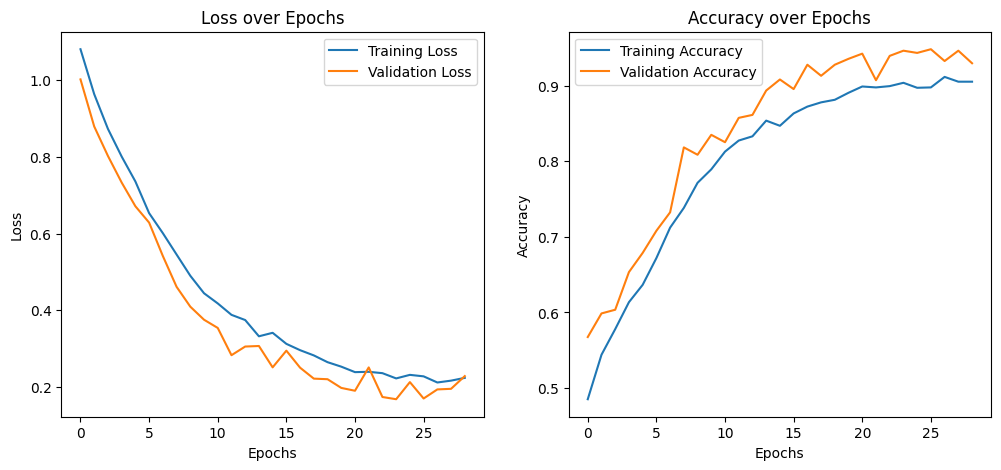

In [12]:
plt.figure(figsize=(12, 5)) # Define a reasonable figure size for our plot

plt.subplot(1, 2, 1) # Construct a 2x1 grid plot
plt.plot(history.history['loss'], label='Training Loss') # Plot within the first graph the loss as a function of the epochs
plt.plot(history.history['val_loss'], label='Validation Loss')  # Plot within the first graph the val loss as a function of the epochs
plt.xlabel('Epochs') # Label the X axis
plt.ylabel('Loss') # Label the Y axis
plt.title('Loss over Epochs') # Apply a title to the first graph
plt.legend() # Create a legend, to match graph colors with their corresponding labels

# All similar as before, just for accuracy and val accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.show() # Finally show the plot

In [13]:
model.save('/content/drive/My Drive/Trained Models/Alzheimer_Model.h5') # Save the model and it's architecture inside the drive


In [12]:
import tensorflow as tf
from tensorflow.keras.models import load_model

model = load_model('/content/drive/MyDrive/Trained Models/Alzheimer_Model.h5') # Load the model's architecture
model.summary() # Summarize the model to ensure we're dealing with the most recent model

# After our model is finally trained, we can now predict the model on unique images it has likely never seen
def preprocess_image(image_path):
    """"

        Receives the path of an image and opens it while pre-processing it to fit the requirements of our neural network

    """
    img = Image.open(image_path) # Open the image from the parameter path
    img = img.resize((IMG_SIZE, IMG_SIZE))  # Resize to match model input size
    img = img.convert('RGB')  # Ensure the image has 3 channels
    img_arr = np.array(img) / 255.0  # Normalize the image color channels
    img_arr = img_arr.astype(np.float32) # Convert integers into 36 bit integers to match the neural network's processing
    img_arr = np.expand_dims(img_arr, axis=0)  # Add batch dimension
    return img_arr

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 178, 178, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 89, 89, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 87, 87, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 43, 43, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 41, 41, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 20, 20, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 51200)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       3,276,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │             260 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,370,374 (12.86 MB)

 Trainable params: 3,370,372 (12.86 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [14]:
def classify_image(dir):
    """"

        Receives the path of an image, and outputs the model's classifications of that image.

    """
    test_image = preprocess_image(dir) # Preprocess the image
    output = model.predict(test_image) # Use the model and predict the output on the image
    probabilities = output[0]
    class_prediction = np.argmax( probabilities ) # Pick the index of the prediction with the highest probability
    print(f"Probabilities are {probabilities}, predicted class is: {class_prediction}") # Output contents

classify_image("/content/test.jpg") # Use the classification function

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Probabilities are [1.6350504e-20 0.0000000e+00 8.7401759e-08 9.9999988e-01], predicted class is: 3


In [16]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

predictions = model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)

40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


<Axes: >

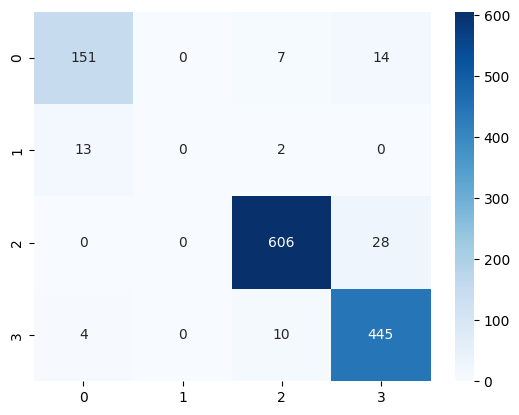

In [17]:
cm = confusion_matrix(test_df['label'].values, predicted_classes) # Confusion matrix
cm_df = pd.DataFrame(cm) # Convert our confusion matrix into a dataframe so that we can visualize it using seaborn
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')